# Load the pred_T file and the gold file

In [1]:
pred_file = 'analysis/predT_not_in_original_pmid_predTs.json'
gold_file = 'data/KD-DTI/raw/test.json'

In [2]:
import json

# load the pmids that the pred_Ts are not in the original articles
with open (pred_file, 'r') as f:
    pred_d_not_in_original = json.load(f)

print(len(pred_d_not_in_original))
print(pred_d_not_in_original[0])

823
{'id': '11169165', 'predT_not_in_original': ['monoamine oxidase type b (mao-b)', 'monoamine oxidase type a (mao-a)']}


In [3]:
# load the gold standard
with open (gold_file, 'r') as f:
    gold_d = json.load(f)

print(len(gold_d))
print(gold_d[pred_d_not_in_original[0]['id']])

1159
{'title': 'Inhibition of rat brain monoamine oxidase activities by psoralen and isopsoralen: implications for the treatment of affective disorders.', 'abstract': 'Psoralen and isopsoralen, furocoumarins isolated from the plant Psoralea corylifolia L., were demonstrated to exhibit in vitro inhibitory actions on monoamine oxidase (MAO) activities in rat brain mitochondria, preferentially inhibiting MAO-A activity over MAO-B activity. This inhibition of enzyme activities was found to be dose-dependent and reversible. For MAO-A, the IC50 values are 15.2 +/- 1.3 microM psoralen and 9.0 +/- 0.6 microM isopsoralen. For MAO-B, the IC50 values are 61.8 +/- 4.3 microM psoralen and 12.8 +/- 0.5 microM isopsoralen. Lineweaver-Burk transformation of the inhibition data indicates that inhibition by both psoralen and isopsoralen is non-competitive for MAO-A. The Ki values were calculated to be 14.0 microM for psoralen and 6.5 microM for isopsoralen. On the other hand, inhibition by both psoralen

# Load the model

In [4]:
import torch
from src.transformer_lm_prompt import TransformerLanguageModelPrompt
m = TransformerLanguageModelPrompt.from_pretrained(
        "checkpoints/RE-DTI-BioGPT", 
        "checkpoint_avg.pt", 
        "data/KD-DTI/relis-bin",
        tokenizer='moses', 
        bpe='fastbpe', 
        bpe_codes="data/bpecodes",
        max_len_b=1024,
        beam=5)
m.cuda()

2023-04-23 00:51:26 | INFO | fairseq.file_utils | loading archive file checkpoints/RE-DTI-BioGPT
2023-04-23 00:51:26 | INFO | fairseq.file_utils | loading archive file data/KD-DTI/relis-bin
2023-04-23 00:51:28 | INFO | src.language_modeling_prompt | dictionary: 42384 types
2023-04-23 00:51:31 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': '../../src', 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerLanguageModelPrompt(
      (decoder): TransformerDecoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(42393, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layers): ModuleList(
          (0-23): 24 x TransformerDecoderLayerBase(
            (dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_dropout_module): FairseqDropout()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwis

In [5]:
# because it's hard to use the moses tokenizer.decode() to show the different between the 4 (= 4#) and 4</w>
# so here using the tokenizer from HF to decode each generated token, and it doesn't include the learn0 - learn9, which is not a problem
from transformers import BioGptTokenizer

tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# inference step by step

In [6]:
# a test data: {"pmid": ,
#               "id": ,
#               "title+abstract.lower()": ,
#               "text_tokens": ,
#               "pred_Ts": ,
#              "pred_Ts_tokens": ,}
#               "gold_triples": ,}

def get_test_data(id):
    prefix = torch.arange(42384, 42393)
    test_data = {}
    test_data['pmid'] = pred_d_not_in_original[id]['id']
    test_data['text'] = gold_d[test_data['pmid']]['title'].strip() + " " + gold_d[test_data['pmid']]['abstract']
    test_data['text'] = test_data['text'].lower().strip().replace('  ', ' ')
    test_data['text_tokens'] = m.encode(test_data['text'])
    test_data['text_tokens_with_prefix'] = torch.cat([test_data['text_tokens'], prefix], dim=-1).unsqueeze(0).cuda()
    test_data['pred_Ts'] = pred_d_not_in_original[id]['predT_not_in_original']
    test_data['pred_Ts_tokens'] = [m.encode(pred_T) for pred_T in test_data['pred_Ts']]
    test_data['gold_triples'] = gold_d[test_data['pmid']]['triples']
    return test_data

In [7]:
test_data = get_test_data(66)

print(f'{{\n"pred_Ds": "{test_data["pred_Ts"][0]}",')
print('"gold": {')
for key, value in test_data["gold_triples"][0].items():
    print(f'"{key}": "{value}",')
print('},')
# print(f'"gold": {test_data["gold_triples"][0]},')
print(f'"text": "{test_data["text"]}"\n}}')

{
"pred_Ds": "caax farnesyltransferase beta (fntb)",
"gold": {
"drug": "PD-83176",
"target": "Farnesyl protein transferase (Ftase)",
"interaction": "inhibitor",
},
"text": "structure-activity relationships of cysteine-lacking pentapeptide derivatives that inhibit ras farnesyltransferase. mutational activation of ras has been found in many types of human cancers, including a greater than 50% incidence in colon and about 90% in pancreatic carcinomas. the activity of both native and oncogenic ras proteins requires a series of post-translational processing steps. the first event in this process is the farnesylation of a cysteine residue located in the fourth position from the carboxyl terminus of the ras protein, catalyzed by the enzyme farnesyltransferase (ftase). inhibitors of ftase are potential candidates for development as antitumor agents. through a high-volume screening program, the pentapeptide derivative pd083176 (1), cbz-his-tyr(obn)-ser(obn)-trp-dala-nh2, was identified as an in

In [8]:
for token_id in test_data['text_tokens_with_prefix'][0]:
    print(f'"{token_id.item()}": "{tokenizer.convert_ids_to_tokens([token_id])[0]}",')

"347": "structure</w>",
"9": "@-@</w>",
"79": "activity</w>",
"1498": "relationships</w>",
"5": "of</w>",
"3888": "cysteine</w>",
"9": "@-@</w>",
"3086": "lacking</w>",
"4472": "pent",
"13946": "apeptide</w>",
"2025": "derivatives</w>",
"22": "that</w>",
"1712": "inhibit</w>",
"6808": "ras</w>",
"19962": "farnes",
"1511": "yl",
"20477": "transfer",
"1344": "as",
"36448": "e.</w>",
"10510": "mutational</w>",
"315": "activation</w>",
"5": "of</w>",
"6808": "ras</w>",
"57": "has</w>",
"58": "been</w>",
"95": "found</w>",
"10": "in</w>",
"462": "many</w>",
"539": "types</w>",
"5": "of</w>",
"108": "human</w>",
"1636": "cancers</w>",
"7": ",</w>",
"197": "including</w>",
"14": "a</w>",
"368": "greater</w>",
"48": "than</w>",
"297": "50</w>",
"24": "%</w>",
"512": "incidence</w>",
"10": "in</w>",
"1963": "colon</w>",
"8": "and</w>",
"255": "about</w>",
"791": "90</w>",
"24": "%</w>",
"10": "in</w>",
"1414": "pancreatic</w>",
"14088": "carcin",
"23491": "omas",
"4": ".</w>",
"6": "the</w>",
"

In [56]:
# initialize
test_input = test_data['text_tokens_with_prefix']

output_text = []
k = 5
prob = []
ranking = []
step = 0

with torch.no_grad():
    for i in range(3):
        m.models[0].decoder.eval()
        step += 1

        out = m.models[0].decoder(test_input)

        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)
        top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
        top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
        top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
        # print(f'The top-{k} most possible tokens are:\n{top_k}')
        next_token_id = 1
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])

        prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        ranking.append(next_token_id)

    while (next_token_id != 0):        
        print(f'output_text: {m.decode(output_text)}\n')
        step += 1

        out = m.models[0].decoder(test_input)
        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)
        top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
        top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
        top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
        print(f'The top-{k} most possible tokens are:\n{top_k}')
        next_token_id = int(input('Please input the next token (0 to end, -1 to input Customized string):'))
        if next_token_id == 0:
            break
        if next_token_id == -1:
            customized_string = input('Please input the Customized string:')
            customized_string_tokens = torch.tensor(tokenizer.convert_tokens_to_ids(customized_string)).unsqueeze(0).cuda()
            test_input = torch.cat([test_input[0], customized_string_tokens], dim=-1).unsqueeze(0)
            output_text.append(customized_string_tokens.squeeze(0))

            customized_string_prob = out[0][0][-1][customized_string_tokens].clone()
            sorted_output, _ = torch.sort(out[0][0][-1], descending=True)
            print(f'The {customized_string} has the {torch.where(sorted_output == customized_string_prob)[0].item() + 1} / {len(sorted_output)} biggest probability in output.')
            
            prob.append(softmax_out[customized_string_tokens].item())
            ranking.append(torch.where(sorted_output == customized_string_prob)[0].item() + 1)

            continue
        if next_token_id != 1:
            sorted_output, _ = torch.sort(out[0][0][-1], descending=True)
            print(f'The token has the {next_token_id} / {len(sorted_output)} biggest probability in output.')
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])

        prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        ranking.append(next_token_id)


output_text: the interaction between

The top-5 most possible tokens are:
[(['p'], 0.6539740562438965), (['b'], 0.10038413852453232), (['c'], 0.08974198997020721), (['n'], 0.08479052037000656), (['g'], 0.07110932469367981)]
output_text: the interaction between p

The top-5 most possible tokens are:
[(['d</w>'], 0.43064385652542114), (['mid'], 0.42220813035964966), (['d'], 0.0804949626326561), (['f</w>'], 0.035377055406570435), (['nu</w>'], 0.03127598762512207)]
The token has the 3 / 42393 biggest probability in output.
output_text: the interaction between pd

The top-5 most possible tokens are:
[(['z</w>'], 0.3260069489479065), (['g'], 0.24092155694961548), (['c'], 0.14578792452812195), (['t'], 0.14401677250862122), (['d</w>'], 0.14326676726341248)]
The 0 has the 14 / 42393 biggest probability in output.
output_text: the interaction between pd0

The top-5 most possible tokens are:
[(['8'], 0.813526451587677), (['6'], 0.08176296949386597), (['5'], 0.04198750481009483), (['7'], 0.0345043

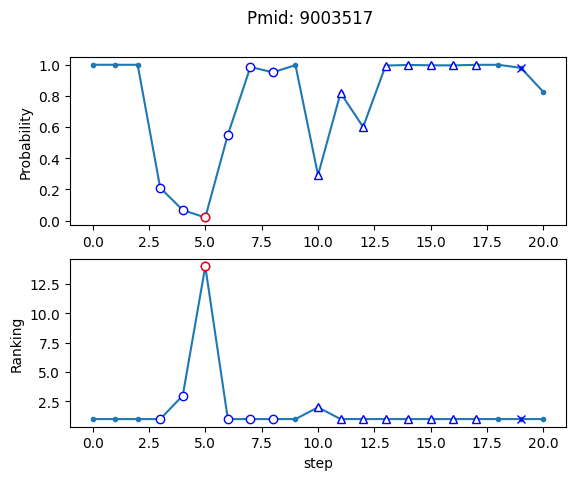

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Create some fake data.
x = np.arange(step-1)
y1 = prob
y2 = ranking

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f'Pmid: {test_data["pmid"]}')

ax1.plot(x, y1, '.-')
ax1.set_ylabel('Probability')

ax2.plot(x, y2, '.-')
ax2.set_xlabel('step')
ax2.set_ylabel('Ranking')

marks = [0]* (step-1)
mark = False

# 0 for  parttern tokens, 1 for drugs ,2 for targets, 3 for interaction
for i, token in enumerate(output_text):
    if token != 6 and output_text[i-1] == 45:
        marks[i] = 1
        mark = True
        continue
    if token == 8 or token == 21 or token == 4:
        continue
    if token != 6 and output_text[i-1] == 8:
        marks[i] = 2
        mark = True
        continue
    if token != 6 and output_text[i-1] == 21:
        marks[i] = 3
        mark = True
        continue
    if token == 44:
        mark = False
        continue
    if mark:
        marks[i] = marks[i-1]
        

# if marks[x] == 1, then using hollow circle for the plot, if marks[x] == 2, then using hollow triangle for the plot, if marks[x] == 3, then using star for the plot.
for i in range(step-1):
    if marks[i] == 1:
        ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='red')
            ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='red')

    if marks[i] == 2:
        ax1.plot(x[i], y1[i], marker='^', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='^', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='^', color='red')
            ax2.plot(x[i], y2[i], marker='^', color='red')

    if marks[i] == 3:
        ax1.plot(x[i], y1[i], marker='x', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='x', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='x', color='red')
            ax2.plot(x[i], y2[i], marker='x', color='red')


plt.savefig(f'analysis/img/{test_data["pmid"]}-*.png')
plt.show()